In [1]:
import tensorflow as tf


In [58]:
import pandas as pd
import h5py
import numpy as np
from sklearn.model_selection import train_test_split

file = h5py.File(f'C:\\Users\\Jake\\Desktop\\ai-playground\\doodle-detection\\dataset\\QuickDrawImages19.h5','r')

mapping = ['marker', 'matches', 'megaphone', 'mermaid', 'microphone', 'microwave', 'monkey', 'moon', 'mosquito', 'motorbike']

images = np.array(file['images'])
images = np.expand_dims(images,axis=3)
#print(images.shape)
labels = np.array(file['targets'])
labels = labels-min(labels) #make labels start from zero

targets = []
for label in labels:
    onehot = np.zeros(10)
    onehot[label] = 1
    targets.append(onehot)
    
targets = np.array(targets)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

X_train, X_test, y_train, y_test = train_test_split(images,targets,test_size=.1,shuffle=True)

train_datagen.fit(X_train)
test_datagen.fit(X_test)

In [2]:
def get_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(96,96,1)),
        tf.keras.layers.Conv2D(64,(3,3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='valid'),
        tf.keras.layers.Conv2D(64,(3,3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='valid'),
        tf.keras.layers.Conv2D(64,(3,3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation="relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512,activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256,activation="relu"),
        tf.keras.layers.Dense(10,activation="softmax") #probability distribution output
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics="accuracy"
    )
    model.build()
    return model

In [3]:
model = get_model()

In [63]:
model.fit(train_datagen.flow(X_train, y_train, batch_size=32,subset='training'),
          epochs=30,
          validation_data=train_datagen.flow(X_train, y_train,batch_size=8, subset='validation'),
          callbacks=[
              tf.keras.callbacks.ReduceLROnPlateau(
                  monitor='val_accuracy', 
                  patience=3,
                  min_delta=0.0001,
                  factor=0.25,
                  min_lr=0.000001
                ),
              tf.keras.callbacks.EarlyStopping(
                  monitor='val_accuracy', 
                  patience=6, 
                  verbose=2,
                  mode='max',
                  restore_best_weights=True
                ),
              tf.keras.callbacks.ModelCheckpoint(
                     filepath='C:\\Users\\Jake\\Desktop\\ai-playground\\doodle-detection\\models\\model_best.h5', 
                     save_freq='epoch', verbose=1, monitor='val_accuracy', mode="max",
                     save_weights_only=True, save_best_only=True
                )   
          ])

Epoch 1/30
  49/2250 [..............................] - ETA: 46s - loss: 2.0004 - accuracy: 0.3029

KeyboardInterrupt: 

In [4]:
model.load_weights('C:\\Users\\Jake\\Desktop\\ai-playground\\doodle-detection\\models\\model_.8768valacc.h5')

In [5]:
#model.save('C:\\Users\\Jake\\Desktop\\ai-playground\\doodle-detection\\models\\model_.8768valacc.keras')

1/1 [==============================] - 0s 37ms/step
microwave
TRUE: microwave,PREDICT: microwave, 99.93%


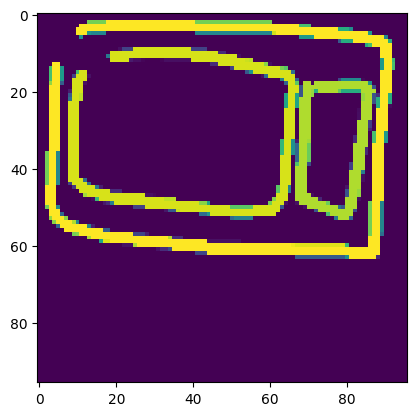

1/1 [==============================] - 0s 36ms/step
microwave
TRUE: microwave,PREDICT: microwave, 99.37%


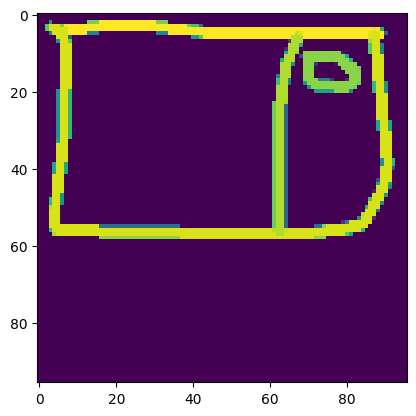

1/1 [==============================] - 0s 38ms/step
marker
TRUE: marker,PREDICT: marker, 65.0%


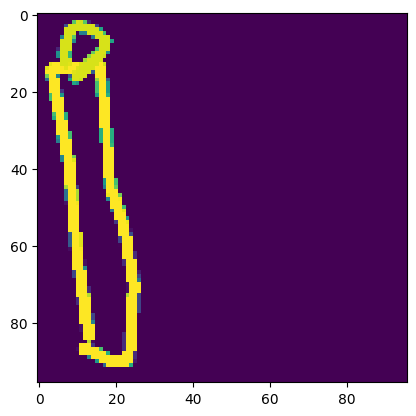

1/1 [==============================] - 0s 37ms/step
motorbike
TRUE: motorbike,PREDICT: motorbike, 100.0%


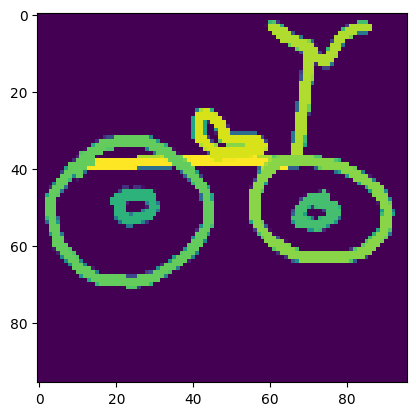

1/1 [==============================] - 0s 35ms/step
microwave
TRUE: microwave,PREDICT: microwave, 83.27%


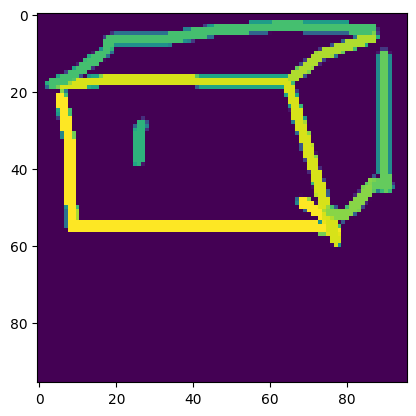

1/1 [==============================] - 0s 35ms/step
microphone
TRUE: microphone,PREDICT: microphone, 93.81%


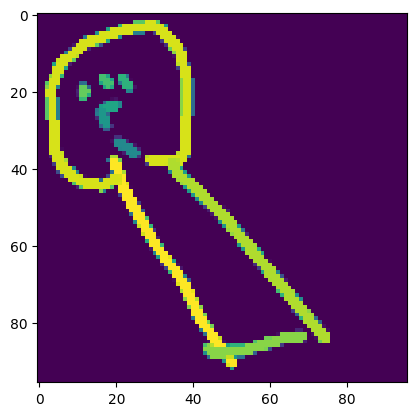

1/1 [==============================] - 0s 32ms/step
mermaid
TRUE: mermaid,PREDICT: mermaid, 99.09%


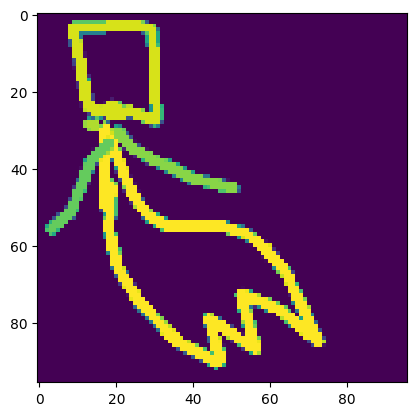

1/1 [==============================] - 0s 35ms/step
marker
TRUE: marker,PREDICT: marker, 99.85%


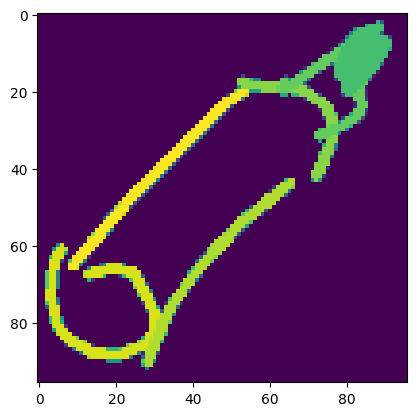

1/1 [==============================] - 0s 34ms/step
moon
TRUE: moon,PREDICT: moon, 99.32%


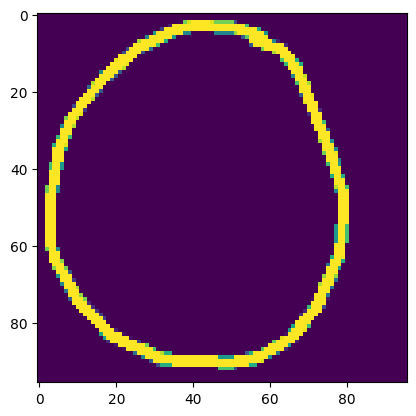

1/1 [==============================] - 0s 36ms/step
matches
TRUE: marker,PREDICT: matches, 43.55%


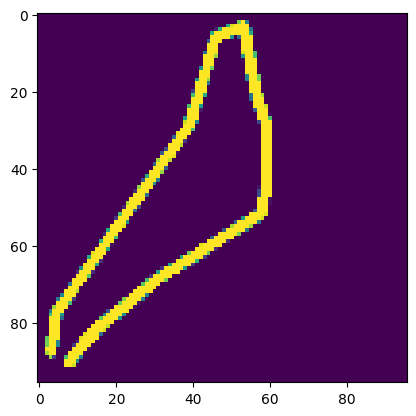

In [ ]:
from matplotlib import pyplot as plt


for i in range(10):
    img = X_test[i]
    label = np.argmax(y_test[i])
    pred = model.predict(test_datagen.flow(np.array([img])))[0]
    pred_label = np.argmax(pred)
    perc = pred[pred_label]
    print(f'TRUE: {mapping[label]},PREDICT: {mapping[pred_label]}, {round(perc*100,2)}%')
    plt.imshow(img, interpolation='nearest')
    plt.show()
